In [1]:
import torch
import torch.nn.functional as F
import torchvision
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import subprocess as sp
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
import pickle

## Config

In [2]:
SEARCH_BS = False
# SEARCH_BS = True
SEARCH_LR = False
# SEARCH_LR = True

In [3]:
DEBUG = False
# DEBUG = True
TRAIN_ONE_SAMPLE = False
# TRAIN_ONE_SAMPLE = True
SUBCONJUNT = False
# SUBCONJUNT = True
GRADIENT_ACUMULATION = False
GRADIENT_ACUMULATION = True

# Resize images
resize_img = 1300
if DEBUG:
    resize_img = 100
if TRAIN_ONE_SAMPLE:
    resize_img = 100
if SUBCONJUNT:
    resize_img = 700
if GRADIENT_ACUMULATION:
    resize_img = 1900
resize_img = 32*(resize_img//32)

# Subconjunt division factor
if SUBCONJUNT:
    division_factor = 10

# Train batch size
BS_train = 4
if SEARCH_LR:
    BS_train = BS_train//4
    if BS_train == 0:
        BS_train = 1
if DEBUG:
    BS_train = 32
if TRAIN_ONE_SAMPLE:
    BS_train = 32
if SUBCONJUNT:
    BS_train = 8
if GRADIENT_ACUMULATION:
    BS_train = 32
    BS_grad_accum = 2

# Validation batch size
BS_val = BS_train * 4
if GRADIENT_ACUMULATION:
    BS_val = 8

# Train
EPOCHS = 400
if DEBUG:
    EPOCHS = 3
if TRAIN_ONE_SAMPLE:
    EPOCHS = 100
if SUBCONJUNT:
    EPOCHS = 100

# Learning rate
LR = 1e-2

# Save best model
NOTEBOOK_NAME = '14_resnet50_big_BS'

# Dataset split
VALID_SPLIT = 0.2

# Model
number_of_classes = 2 # 2 classes
number_of_channels = 3
encoder_name = 'resnet50'
encoder_weights = 'imagenet'
activation = None
name_best_model = f'{NOTEBOOK_NAME}_best_model.pth'
name_early_stopping_model = f'{NOTEBOOK_NAME}_early_stopping.pth'
name_final_model = f'{NOTEBOOK_NAME}_final_model.pth'
path_to_save_models = path = Path("../models/")
path_best_model = path_to_save_models / name_best_model
path_early_stopping_model = path_to_save_models / name_early_stopping_model
path_final_model = path_to_save_models / name_final_model

# Learning rate decay
LE_DECAY_FACTOR = 0.1
LE_DECAY_PATIENCE = 10

# Early stopping
EARLY_STOPPING = False
EARLY_STOPPING_PATIENCE = 30

# Epochs when model can be saved
MIN_SAVE_EPOCHS = 10

## Dataframe

In [4]:
path = Path("../")
data_path = path / "data"
os.listdir(data_path)

['train_images',
 'test_images',
 'train_annotations',
 'train.csv',
 'sample_submission.csv',
 'test.csv',
 'submission.csv',
 'HuBMAP - Hacking the Kidney']

In [5]:
train_images_path = data_path / "train_images"

In [6]:
train_df = pd.read_csv(data_path / "train.csv")
train_df['path'] = train_df.id.apply(lambda x: f'{str(train_images_path)}/{x}.tiff')
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../data/train_images/10044.tiff
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../data/train_images/10274.tiff
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../data/train_images/10392.tiff
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../data/train_images/10488.tiff
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../data/train_images/10610.tiff


## Dice coefficient loss

In [7]:
def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(1)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    intersection = (m1 * m2).sum().float()
    dice = (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)
    dice = dice.item()

    return dice

## Dataset and Dataloader

In [8]:
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    if len(shape) == 3:
        img = img.reshape(shape[0], shape[1])
    else:
        img = img.reshape(shape[0], shape[1])
    return img.T

In [9]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, dataframe, n_classes=2, dim=2000, interpolation=cv2.INTER_LANCZOS4):
    self.dataframe = dataframe
    self.n_classes = n_classes
    self.dim = dim
    self.interpolation = interpolation

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, ix):
    img_path = str(self.dataframe.iloc[ix]['path']) # Get image path from column 'path' in dataframe
    img_cv = cv2.imread(img_path) # Load image
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    img_cv_res = cv2.resize(img_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation) # Resize image
    img_cv_res_norm = img_cv_res / 255.0  # Normalize image
    img_tensor = torch.from_numpy(img_cv_res_norm).float().permute(2, 0, 1) # Convert to tensor

    rle = self.dataframe.iloc[ix]['rle']  # Get mask
    mask_cv = rle2mask(rle, img_cv.shape) # Convert mask to numpy array
    mask_cv_res = cv2.resize(mask_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation) # Resize mask
    mask_oh = np.eye(2)[mask_cv_res.astype(int)].astype(np.float32) # One-hot encode mask
    mask_tensor = torch.from_numpy(mask_oh).float().permute(2, 0, 1)  # Convert to tensor
    
    return img_tensor, mask_tensor

In [10]:
train_split, val_split = train_test_split(train_df, test_size=VALID_SPLIT, shuffle=True, random_state=42, stratify=train_df['organ'])
print(f"Había {len(train_df)} imágenes en el dataset, lo hemos dividido en {len(train_split)} imágenes de entrenamiento y {len(val_split)} imágenes de validación")

Había 351 imágenes en el dataset, lo hemos dividido en 280 imágenes de entrenamiento y 71 imágenes de validación


In [11]:
dataset = {
    'train': Dataset(train_split, n_classes=number_of_classes, dim=resize_img),
    'val': Dataset(val_split, n_classes=number_of_classes, dim=resize_img),
}

In [12]:
bs_train = BS_grad_accum if GRADIENT_ACUMULATION else BS_train
print(bs_train, BS_val)

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=bs_train, shuffle=True, pin_memory=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=BS_val, pin_memory=True)
}

2 8


## Model initialization

In [13]:
def model_init():
    model = smp.Unet(encoder_name, encoder_weights=encoder_weights, in_channels=number_of_channels, classes=number_of_classes, activation=activation)
    return model

## Batch size finder

In [14]:
if SEARCH_BS:
    model = model_init()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    if torch.cuda.is_available():
        if torch.cuda.device_count() >= 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            model = torch.nn.DataParallel(model)
        else:
            model.cuda()
    else:
        print("Using CPU")

In [15]:
if SEARCH_BS:
    LR = 1e-3
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

In [16]:
if SEARCH_BS:
    def train_loop(dataloader, model, loss_fn, optimizer):
        model.train()
        for (imgs, masks) in dataloader:
            # X and y to device
            imgs, masks = imgs.to(device), masks.to(device)

            # Compute prediction and loss
            pred_mask = model(imgs)
            loss = criterion(pred_mask, masks)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [17]:
if SEARCH_BS:
    def list_of_posible_batch_sizes(dataset):
        batch_sizes = []
        batch_size = 1
        while batch_size < 2*len(dataset):
            batch_sizes.append(batch_size)
            batch_size *= 2
        batch_sizes.sort(reverse=True)
        return batch_sizes

    BSs = list_of_posible_batch_sizes(dataset['train'])
    print(BSs)

In [18]:
if SEARCH_BS:
    for batchsize_train in BSs:
        print(f"batch size: {batchsize_train}")
        train_dl = torch.utils.data.DataLoader(dataset['train'], batch_size=batchsize_train, shuffle=True, pin_memory=True)
        epochs = 3
        out_of_memory = False
        for t in range(epochs):
            print(f"\tTrain epoch {t} of {epochs}")
            try:
                train_loop(train_dl, model, optimizer, optimizer)
            except Exception as e:
                if "CUDA out of memory" in str(e):
                    position = str(e).index('CUDA out of memory')
                    print(f"\t{str(e)[position:]}")
                    out_of_memory = True
                    break
                else:
                    out_of_memory = False
                break
        if out_of_memory == False:
            break
        print()
    print(f"Done!, bacth size is {batchsize_train}")

In [19]:
if SEARCH_BS:
    BS_train = batchsize_train
    BS_val = BS_train * 4
    print(f"For {resize_img}x{resize_img} images size, we use batch size of {BS_train} for train and batch size of {BS_val} for validation")

## Search LR

In [20]:
if SEARCH_LR:
    def lr_finder(model, train_dl, loss_fn, device, lr_init=1e-8, lr_end=10, increment=4, beta=0.98):
        num = len(train_dl)-1 # Numero de lrs que vamos a probar
        q = (lr_end/lr_init)**(1/num) # Incremento de lr
        lr = lr_init
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss = 0
        best_loss = 0.
        avg_loss = 0.
        smoothed_avg_losses = []
        lrs = []
        for batch, (imgs, masks) in enumerate(train_dl):
            # X and y to device
            imgs, masks = imgs.to(device), masks.to(device)

            # Update optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # Compute prediction and loss
            pred_mask = model(imgs)
            loss = loss_fn(pred_mask, masks)
            avg_loss = beta * avg_loss + (1-beta) * loss.to("cpu").item()
            smoothed_loss = avg_loss / (1 - beta**(batch+1))
            if increment is not None:
                # Se para si el loss se dispara
                window = 10
                if batch > window and smoothed_avg_losses[-window] > increment * best_loss:
                    return lrs, smoothed_avg_losses
            
            # Se guarda la menor pérdida
            if avg_loss < best_loss or batch==0:
                best_loss = smoothed_loss
            
            # Se guardan los datos
            smoothed_avg_losses.append(smoothed_loss)
            lrs.append(lr)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update lr
            lr *= q

        return lrs, smoothed_avg_losses

In [21]:
if SEARCH_LR:
    model = model_init()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    criterion = torch.nn.BCEWithLogitsLoss()
    [lrss, smoothed_avg_losses] = lr_finder(model, train_dl=dataloader['train'], loss_fn = criterion, device=device)

    plt.plot(lrss, smoothed_avg_losses)
    plt.xlabel("lr")
    plt.ylabel("loss")
    plt.xscale("log")
    plt.grid()
    plt.show()

In [22]:
if SEARCH_LR:
    LR = 1e-2

## Train all images

In [23]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_loop(dataloader, model, loss_fn, optimizer, bar, hist, device, epoch, epochs):
    debug = False
    train_loss, train_dice = [], []
    model.train()
    count = 0 # Counter for gradient accumulation
    # for imgs, masks in progress_bar(dataloader['val'], parent=mb):
    for imgs, masks in bar:
        if debug: print(f"gradient accumulation count = {count}")
        if debug: print(f"batch size = {imgs.shape[0]}, batch size train = {BS_train}, batch size grad acc = {BS_grad_accum}")
        # X and y to device
        imgs, masks = imgs.to(device), masks.to(device)
        # Compute prediction and loss
        pred_mask = model(imgs)
        loss = loss_fn(pred_mask, masks)
        # Backpropagation
        if count == 0:
            if debug: print("zero grad")
            optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Update counter for gradient accumulation
        count += len(imgs)
        if debug: print(f"count = {count} ")
        if count >= BS_train:
            if debug: print("reset gradien accumulation counter")
            count = 0
        # Update train loss and dice
        dice = dice_coeff(pred_mask, masks)
        train_loss.append(loss.item())
        train_dice.append(dice)
        # Update progress bar
        bar.set_description(f"\tEpoch {epoch}/{epochs}: loss {np.mean(train_loss):.5f}, dice {np.mean(train_dice):.5f}")
    hist['loss'].append(np.mean(train_loss))
    hist['dice'].append(np.mean(train_dice))
    return hist

def valid_loop(dataloader, model, loss_fn, optimizer, bar, hist, device, epoch, epochs):
    val_loss, val_dice = [], []
    model.eval()
    with torch.no_grad():
        # for imgs, masks in progress_bar(dataloader['val'], parent=mb):
        for imgs, masks in bar:
            # X and y to device
            imgs, masks = imgs.to(device), masks.to(device)
            # Compute prediction and loss
            pred_mask = model(imgs)
            loss = loss_fn(pred_mask, masks)
            # Update test loss and dice
            dice = dice_coeff(pred_mask, masks)
            val_loss.append(loss.item())
            val_dice.append(dice)
            # Update progress bar
            bar.set_description(f"\t\tEpoch {epoch}/{epochs}: val_loss {np.mean(val_loss):.5f} val_dice {np.mean(val_dice):.5f}")
    hist['val_loss'].append(np.mean(val_loss))
    hist['val_dice'].append(np.mean(val_dice))
    return hist

def fit(model, dataloader, device, epochs=100, lr=3e-4, parallel=False):
    len_int_epochs = len(str(epochs))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, weight_decay=1e-5)
    criterion = torch.nn.BCEWithLogitsLoss()
    best_dice = 0.
    early_stop_counter = 0
    schedulerOnPlateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=LE_DECAY_FACTOR, patience=LE_DECAY_PATIENCE, verbose=True)
    if torch.cuda.device_count() >= 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        if parallel:
            model = torch.nn.DataParallel(model)
        model.cuda()
    else:
        print("Let's use CPU!")
        model.to(device)
    hist = {'loss': [], 'dice': [], 'val_loss': [], 'val_dice': [], 'lr': []}
    checkpoints = {'best model epoch': 0, 'best model dice': 0, 'early stopping epoch': 0, 'early stopping dice': 0, 'final model epoch': 0, 'final model dice': 0}
    for epoch in range(epochs):
        # Train
        bar = tqdm(dataloader['train'])
        hist = train_loop(dataloader, model, criterion, optimizer, bar, hist, device, epoch, epochs)

        # Validation
        bar = tqdm(dataloader['val'])
        hist = valid_loop(dataloader, model, criterion, optimizer, bar, hist, device, epoch, epochs)
        
        # Save model if best dice
        if hist['val_dice'][-1] > best_dice and epoch >= MIN_SAVE_EPOCHS:
            best_dice = hist['val_dice'][-1]
            torch.save(model, path_best_model)
            print(f"New best dice: {best_dice:.5f}, model saved to {path_best_model}")
            checkpoints['best model epoch'] = epoch
            checkpoints['best model dice'] = best_dice

        # Save lr
        hist['lr'].append(optimizer.param_groups[0]['lr'])
        
        # Update scheduler
        schedulerOnPlateau.step(hist['val_loss'][-1])

        # Early stopping
        if hist['val_dice'][-1] < best_dice:
            early_stop_counter += 1
            if early_stop_counter == EARLY_STOPPING_PATIENCE+1:
                torch.save(model, path_early_stopping_model)
                print(f"Early stopping at epoch {epoch+1}")
                print(f"Early stopping dice: {hist['val_dice'][-1]}, model saved to {path_early_stopping_model}")
                checkpoints['early stopping epoch'] = epoch
                checkpoints['early stopping dice'] = hist['val_dice'][-1]
                if EARLY_STOPPING:
                    break
        else:
            early_stop_counter = 0
        
    # Save final model
    torch.save(model, path_final_model)
    print(f"Final model dice: {hist['val_dice'][-1]}, saved to {path_final_model}")
    checkpoints['final model epoch'] = epoch
    checkpoints['final model dice'] = hist['val_dice'][-1]
    
    return hist, checkpoints

In [24]:
if not SEARCH_BS and not SEARCH_LR:
    model = model_init()
    hist, checkpoints = fit(model, dataloader, device, epochs=EPOCHS, lr=LR, parallel=True)

Let's use 2 GPUs!


		Epoch 10/400: val_loss 0.40741 val_dice 2.37065: 100%|██████████| 9/9 [00:24<00:00,  2.74s/it]


New best dice: 2.37065, model saved to ../models/14_resnet50_big_BS_best_model.pth


		Epoch 11/400: val_loss 0.32667 val_dice 6.99266: 100%|██████████| 9/9 [00:22<00:00,  2.48s/it]


New best dice: 6.99266, model saved to ../models/14_resnet50_big_BS_best_model.pth


		Epoch 15/400: val_loss 0.34247 val_dice 3.29074: 100%|██████████| 9/9 [00:21<00:00,  2.38s/it]


Epoch 00016: reducing learning rate of group 0 to 1.0000e-03.


		Epoch 16/400: val_loss 0.27327 val_dice 7.13716: 100%|██████████| 9/9 [00:21<00:00,  2.37s/it]


New best dice: 7.13716, model saved to ../models/14_resnet50_big_BS_best_model.pth


		Epoch 17/400: val_loss 0.27279 val_dice 8.26686: 100%|██████████| 9/9 [00:21<00:00,  2.36s/it]


New best dice: 8.26686, model saved to ../models/14_resnet50_big_BS_best_model.pth


		Epoch 18/400: val_loss 0.27207 val_dice 8.34458: 100%|██████████| 9/9 [00:21<00:00,  2.36s/it]


New best dice: 8.34458, model saved to ../models/14_resnet50_big_BS_best_model.pth


		Epoch 20/400: val_loss 0.26721 val_dice 8.41693: 100%|██████████| 9/9 [00:21<00:00,  2.36s/it]


New best dice: 8.41693, model saved to ../models/14_resnet50_big_BS_best_model.pth


		Epoch 21/400: val_loss 0.28604 val_dice 8.70158: 100%|██████████| 9/9 [00:21<00:00,  2.36s/it]


New best dice: 8.70158, model saved to ../models/14_resnet50_big_BS_best_model.pth


		Epoch 23/400: val_loss 0.29884 val_dice 9.94843: 100%|██████████| 9/9 [00:21<00:00,  2.38s/it] 


New best dice: 9.94843, model saved to ../models/14_resnet50_big_BS_best_model.pth


		Epoch 24/400: val_loss 0.27702 val_dice 9.96899: 100%|██████████| 9/9 [00:21<00:00,  2.37s/it] 


New best dice: 9.96899, model saved to ../models/14_resnet50_big_BS_best_model.pth


		Epoch 26/400: val_loss 0.35129 val_dice 9.98668: 100%|██████████| 9/9 [00:21<00:00,  2.40s/it] 


New best dice: 9.98668, model saved to ../models/14_resnet50_big_BS_best_model.pth
Epoch 00027: reducing learning rate of group 0 to 1.0000e-04.


		Epoch 37/400: val_loss 0.26902 val_dice 9.65473: 100%|██████████| 9/9 [00:21<00:00,  2.37s/it]


Epoch 00038: reducing learning rate of group 0 to 1.0000e-05.


		Epoch 38/400: val_loss 0.29026 val_dice 10.18294: 100%|██████████| 9/9 [00:21<00:00,  2.37s/it]


New best dice: 10.18294, model saved to ../models/14_resnet50_big_BS_best_model.pth


		Epoch 43/400: val_loss 0.28420 val_dice 10.51672: 100%|██████████| 9/9 [00:21<00:00,  2.38s/it]


New best dice: 10.51672, model saved to ../models/14_resnet50_big_BS_best_model.pth


		Epoch 48/400: val_loss 0.26842 val_dice 9.73340: 100%|██████████| 9/9 [00:21<00:00,  2.38s/it]


Epoch 00049: reducing learning rate of group 0 to 1.0000e-06.


		Epoch 59/400: val_loss 0.27433 val_dice 9.88661: 100%|██████████| 9/9 [00:21<00:00,  2.37s/it]


Epoch 00060: reducing learning rate of group 0 to 1.0000e-07.


		Epoch 70/400: val_loss 0.26914 val_dice 9.82307: 100%|██████████| 9/9 [00:21<00:00,  2.36s/it]


Epoch 00071: reducing learning rate of group 0 to 1.0000e-08.


		Epoch 74/400: val_loss 0.27829 val_dice 9.51016: 100%|██████████| 9/9 [00:21<00:00,  2.37s/it]


Early stopping at epoch 75
Early stopping dice: 9.510162830352783, model saved to ../models/14_resnet50_big_BS_early_stopping.pth


		Epoch 76/400: val_loss 0.28103 val_dice 10.58394: 100%|██████████| 9/9 [00:21<00:00,  2.37s/it]


New best dice: 10.58394, model saved to ../models/14_resnet50_big_BS_best_model.pth


	Epoch 103/400: loss 0.18129, dice 10.00159: 100%|██████████| 140/140 [02:38<00:00,  1.13s/it]
		Epoch 103/400: val_loss 0.27327 val_dice 10.18080: 100%|██████████| 9/9 [00:21<00:00,  2.40s/it]
	Epoch 106/400: loss 0.18129, dice 10.00145: 100%|██████████| 140/140 [02:49<00:00,  1.21s/it]
		Epoch 106/400: val_loss 0.27224 val_dice 10.08563: 100%|██████████| 9/9 [00:22<00:00,  2.49s/it]
		Epoch 107/400: val_loss 0.26723 val_dice 9.81859: 100%|██████████| 9/9 [00:21<00:00,  2.36s/it]


Early stopping at epoch 108
Early stopping dice: 9.818586985270182, model saved to ../models/14_resnet50_big_BS_early_stopping.pth


	Epoch 112/400: loss 0.18129, dice 10.00154: 100%|██████████| 140/140 [02:37<00:00,  1.13s/it]
		Epoch 112/400: val_loss 0.27179 val_dice 10.08378: 100%|██████████| 9/9 [00:21<00:00,  2.35s/it]
	Epoch 114/400: loss 0.18129, dice 10.00148: 100%|██████████| 140/140 [02:38<00:00,  1.13s/it]
		Epoch 114/400: val_loss 0.27734 val_dice 10.30335: 100%|██████████| 9/9 [00:21<00:00,  2.35s/it]
	Epoch 119/400: loss 0.18129, dice 10.00200: 100%|██████████| 140/140 [02:53<00:00,  1.24s/it]
		Epoch 119/400: val_loss 0.27921 val_dice 10.36646: 100%|██████████| 9/9 [00:23<00:00,  2.59s/it]
	Epoch 125/400: loss 0.18129, dice 10.00128: 100%|██████████| 140/140 [02:57<00:00,  1.27s/it]
		Epoch 125/400: val_loss 0.27328 val_dice 10.18469: 100%|██████████| 9/9 [00:23<00:00,  2.65s/it]
	Epoch 128/400: loss 0.18129, dice 10.00128: 100%|██████████| 140/140 [02:54<00:00,  1.25s/it]
		Epoch 128/400: val_loss 0.27564 val_dice 10.23287: 100%|██████████| 9/9 [00:23<00:00,  2.62s/it]
	Epoch 133/400: loss 0.18129, 

New best dice: 10.90118, model saved to ../models/14_resnet50_big_BS_best_model.pth


	Epoch 157/400: loss 0.18129, dice 10.00170: 100%|██████████| 140/140 [02:49<00:00,  1.21s/it]
		Epoch 157/400: val_loss 0.26910 val_dice 10.04740: 100%|██████████| 9/9 [00:23<00:00,  2.59s/it]
	Epoch 160/400: loss 0.18129, dice 10.00175: 100%|██████████| 140/140 [02:50<00:00,  1.22s/it]
		Epoch 160/400: val_loss 0.27491 val_dice 10.19755: 100%|██████████| 9/9 [00:22<00:00,  2.53s/it]
	Epoch 165/400: loss 0.18129, dice 10.00159: 100%|██████████| 140/140 [02:45<00:00,  1.18s/it]
		Epoch 165/400: val_loss 0.28848 val_dice 10.18197: 100%|██████████| 9/9 [00:23<00:00,  2.59s/it]
	Epoch 172/400: loss 0.18129, dice 10.00159: 100%|██████████| 140/140 [02:44<00:00,  1.17s/it]
		Epoch 172/400: val_loss 0.27885 val_dice 10.20757: 100%|██████████| 9/9 [00:23<00:00,  2.58s/it]
	Epoch 173/400: loss 0.18129, dice 10.00165: 100%|██████████| 140/140 [02:44<00:00,  1.18s/it]
		Epoch 173/400: val_loss 0.28071 val_dice 10.37358: 100%|██████████| 9/9 [00:23<00:00,  2.58s/it]
	Epoch 178/400: loss 0.18129, 

Early stopping at epoch 185
Early stopping dice: 9.689925193786621, model saved to ../models/14_resnet50_big_BS_early_stopping.pth


	Epoch 191/400: loss 0.18129, dice 10.00134: 100%|██████████| 140/140 [02:36<00:00,  1.12s/it]
		Epoch 191/400: val_loss 0.27689 val_dice 10.14085: 100%|██████████| 9/9 [00:21<00:00,  2.37s/it]
	Epoch 197/400: loss 0.18128, dice 10.00158: 100%|██████████| 140/140 [02:37<00:00,  1.12s/it]
		Epoch 197/400: val_loss 0.28005 val_dice 10.09153: 100%|██████████| 9/9 [00:21<00:00,  2.37s/it]
	Epoch 198/400: loss 0.18128, dice 10.00155: 100%|██████████| 140/140 [02:37<00:00,  1.12s/it]
		Epoch 198/400: val_loss 0.28980 val_dice 10.23345: 100%|██████████| 9/9 [00:21<00:00,  2.38s/it]
	Epoch 204/400: loss 0.18128, dice 10.00144: 100%|██████████| 140/140 [02:37<00:00,  1.12s/it]
		Epoch 204/400: val_loss 0.27882 val_dice 10.10509: 100%|██████████| 9/9 [00:21<00:00,  2.37s/it]
	Epoch 208/400: loss 0.18128, dice 10.00172: 100%|██████████| 140/140 [02:37<00:00,  1.12s/it]
		Epoch 208/400: val_loss 0.28315 val_dice 10.27387: 100%|██████████| 9/9 [00:21<00:00,  2.36s/it]
	Epoch 209/400: loss 0.18128, 

Final model dice: 10.325725555419922, saved to ../models/14_resnet50_big_BS_final_model.pth


## Check fit

In [25]:
print(f"Best model epoch: {checkpoints['best model epoch']}, dice: {checkpoints['best model dice']}")
print(f"Early stopping epoch: {checkpoints['early stopping epoch']}, dice: {checkpoints['early stopping dice']}")
print(f"Final model epoch: {checkpoints['final model epoch']}, dice: {checkpoints['final model dice']}")

Best model epoch: 153, dice: 10.901178359985352
Early stopping epoch: 184, dice: 9.689925193786621
Final model epoch: 399, dice: 10.325725555419922


In [26]:
if not SEARCH_BS and not SEARCH_LR:
    hist_df = pd.DataFrame(hist)
    print(len(hist_df))
else:
    # Empty dataframe
    hist_df = pd.DataFrame()
hist_df.head()

400


,loss,dice,val_loss,val_dice,lr
0,0.326131,21.442929,0.444975,11.832413,0.01
1,0.274149,10.753265,0.289097,7.474085,0.01
2,0.273983,11.660301,0.289361,6.668435,0.01
3,0.261722,11.748150,0.291299,6.581136,0.01
4,0.259336,8.440848,6.183897,3.591306,0.01


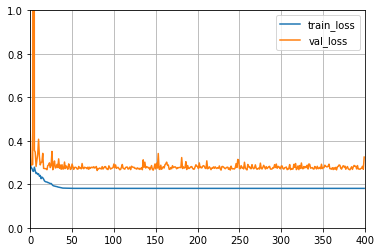

In [27]:
if not SEARCH_BS and not SEARCH_LR:
    # plot the training and testing loss
    plt.plot(hist['loss'], label='train_loss')
    plt.plot(hist['val_loss'], label='val_loss')
    plt.legend()
    plt.xlim(0, len(hist['loss']))
    plt.ylim(0, 1)
    plt.grid()
    plt.show()

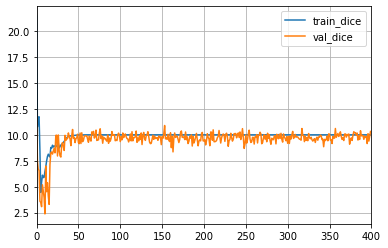

In [28]:
if not SEARCH_BS and not SEARCH_LR:
    # plot the training and testing dice
    plt.plot(hist['dice'], label='train_dice')
    plt.plot(hist['val_dice'], label='val_dice')
    plt.legend()
    plt.xlim(0, len(hist['dice']))
    # plt.ylim(0, 30)
    plt.grid()
    plt.show()

In [29]:
if not SEARCH_BS and not SEARCH_LR:
    sample_val_img, sample_val_mask = next(iter(dataloader['val']))
    one_sample_img = sample_val_img[0]
    one_sample_mask = sample_val_mask[0]

In [30]:
if not SEARCH_BS and not SEARCH_LR:
    def check_model(model, img, mask, type=''):
        model.eval()
        with torch.no_grad():
            img = img.unsqueeze(0).to(device)
            pred_mask = model(img)
            pred_mask = torch.argmax(pred_mask, axis=1)
            pred_mask = pred_mask.squeeze(0).type(torch.float32).detach().cpu().numpy()
            
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
        ax1.imshow(img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy())
        ax1.set_title('Image')
        ax2.imshow(torch.argmax(mask, axis=0).cpu().numpy())
        ax2.set_title('mask')
        ax3.imshow(pred_mask)
        ax3.set_title(f'pred_mask {type}')
        plt.show()

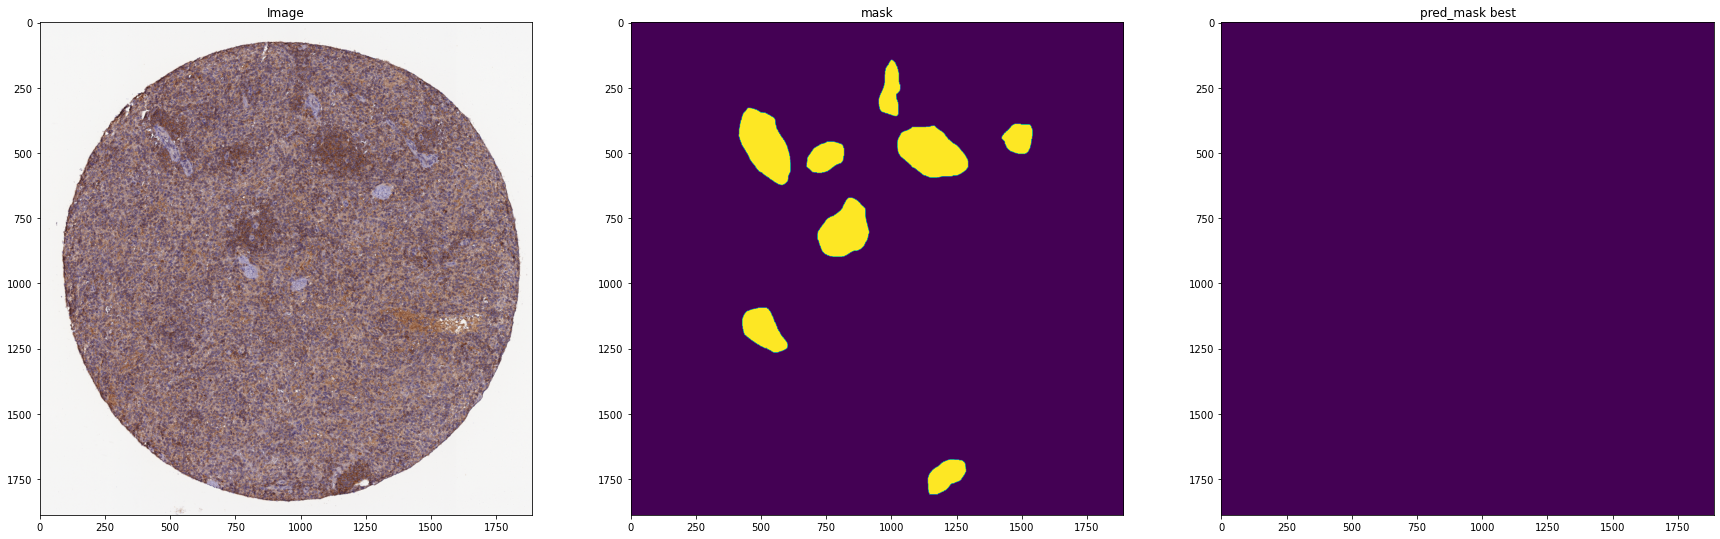

In [31]:
# Best model
if not SEARCH_BS and not SEARCH_LR:
    # if checkpoints['best model epoch'] != 0:
    model = torch.load(path_best_model)
    check_model(model, one_sample_img, one_sample_mask, type='best')

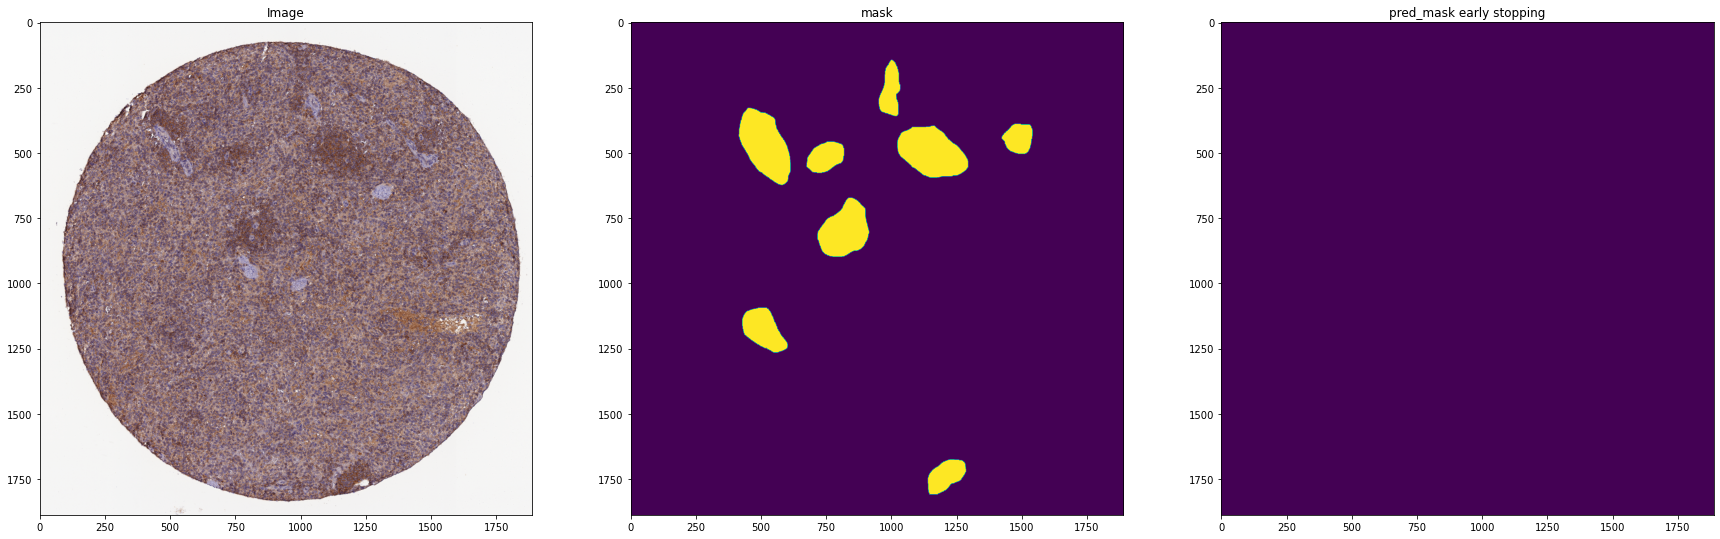

In [32]:
# Early stopping model
if not SEARCH_BS and not SEARCH_LR:
    # if checkpoints['early stopping epoch'] != 0:
    model = torch.load(path_early_stopping_model)
    check_model(model, one_sample_img, one_sample_mask, type='early stopping')

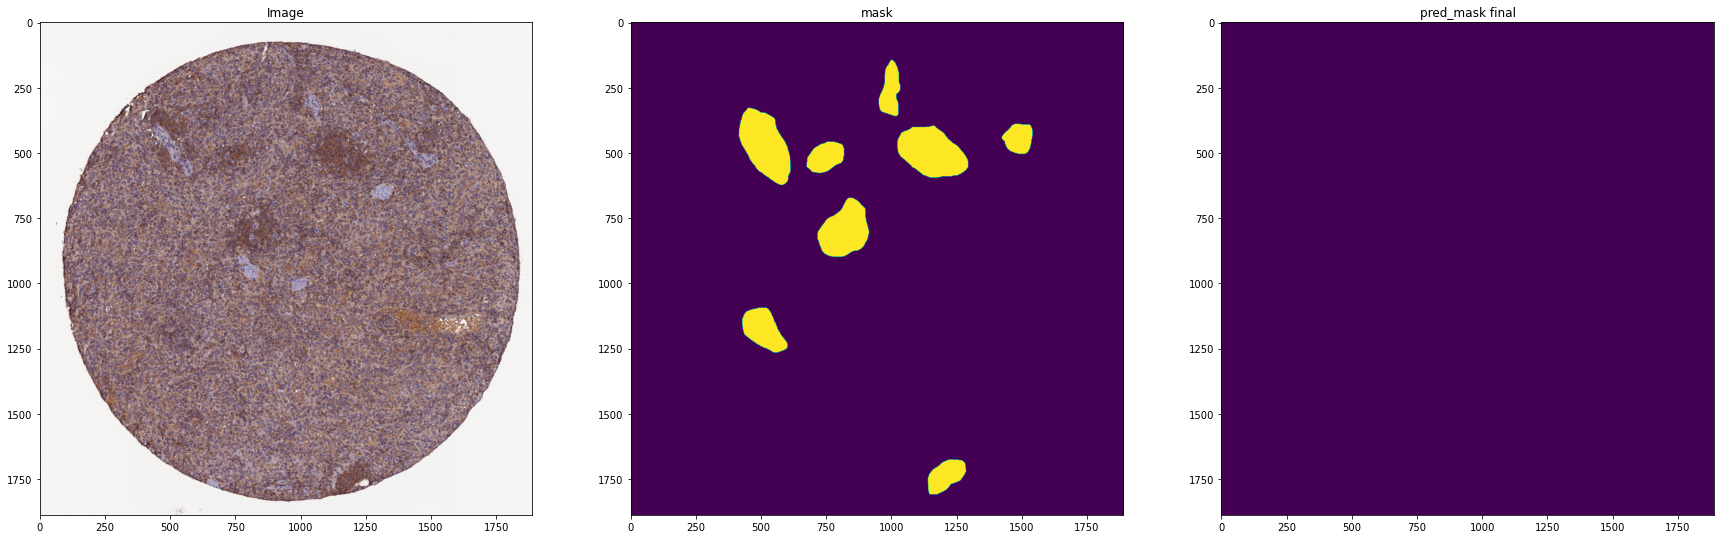

In [33]:
# Final stopping model
if not SEARCH_BS and not SEARCH_LR:
    # if checkpoints['final model epoch'] != 0:
    model = torch.load(path_final_model)
    check_model(model, one_sample_img, one_sample_mask, type='final')